In [182]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.DAGMM import Trainer, DAGMM
from utils.reconstruction_loss import ReconstructionLoss_audio as ReconstructionLoss
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

real_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_train'
real_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_train'


train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'

test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'




workers = 4
feature_dim =16
batchsize = 64
use_attention = 1

checkpoint_path = f'/home/iot/collision_detect/output/DAGMM_{feature_dim}'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = ReconstructionLoss()
loss_function = nn.MSELoss()

real_data = CollisionLoader_new(real_imu,real_audio,train=True)
real_dataloader = DataLoader(real_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

# random_tensor = torch.load('/home/iot/collision_detect/svdd/center_2.pth').to(device)
# print(random_tensor.shape)
model = DAGMM(feature_dim=feature_dim).to(device)
model = model.to(device)

checkpoint = torch.load(os.path.join(checkpoint_path,"last_weights"))
# model.load_state_dict(checkpoint['model_state_dict'])
model.load_checkpoint(checkpoint_path)
# if checkpoint_path != '':
# model.load_state_dict(torch.load(checkpoint_path['model_state_dict']))
# print('Load weights')


cuda
Model loaded from /home/iot/collision_detect/output/DAGMM_16.


In [183]:
model.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

with torch.no_grad():  # Prevent tracking gradients
    for it, (_, image, audio, _, _) in enumerate(real_dataloader):
        image, audio = image.to(device), audio.to(device)
        enc, dec, z, gamma = model(audio, image)
        phi, mu, cov = model.compute_gmm_params(z, gamma)
        
        batch_gamma_sum = torch.sum(gamma, dim=0)
        
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)
        
        N += image.size(0)

train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:", N)
print("phi :\n", train_phi)
print("mu :\n", train_mu)
print("cov :\n", train_cov)


N: 4736
phi :
 tensor([0.0575, 0.0810, 0.7893, 0.0721], device='cuda:0')
mu :
 tensor([[-2.0424, -0.6209,  1.8214, -0.2089, -0.0535, -0.1630, -1.9593, -0.5205,
          0.1693,  1.4190,  0.9589,  0.2999,  0.2373, -0.1463,  0.9800, -0.5159],
        [-2.2137, -0.8645,  2.0539, -0.3882, -0.2428, -0.4130, -1.5677, -0.2936,
         -0.0221,  1.2704,  1.1629,  0.5146, -0.0333,  0.1148,  1.2772, -0.7234],
        [-2.6982, -1.5861,  2.7286, -0.9357, -0.8016, -1.1704, -0.4099,  0.3933,
         -0.5831,  0.8028,  1.7827,  1.1490, -0.8485,  0.8978,  2.1778, -1.3372],
        [-2.1318, -0.8089,  1.9910, -0.3722, -0.1949, -0.3708, -1.6764, -0.3255,
          0.0360,  1.2543,  1.1278,  0.4652,  0.0084,  0.0687,  1.2338, -0.6677]],
       device='cuda:0')
cov :
 tensor([[[ 0.6246,  0.5895, -0.5872,  ..., -0.6099, -0.6548,  0.5360],
         [ 0.5895,  0.8705, -0.8230,  ..., -0.9068, -1.0271,  0.7389],
         [-0.5872, -0.8230,  0.8317,  ...,  0.8531,  0.9775, -0.7260],
         ...,
         [

tensor([-2.5302], device='cuda:0', grad_fn=<SubBackward0>)


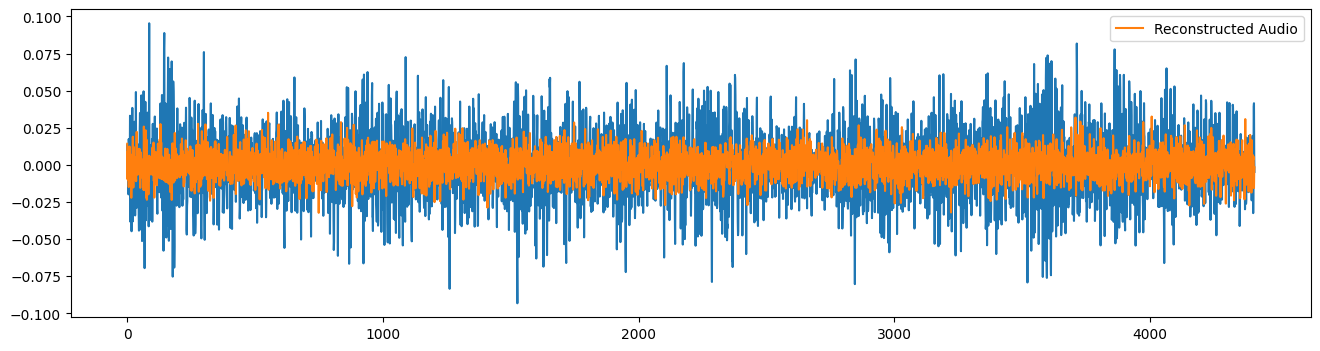

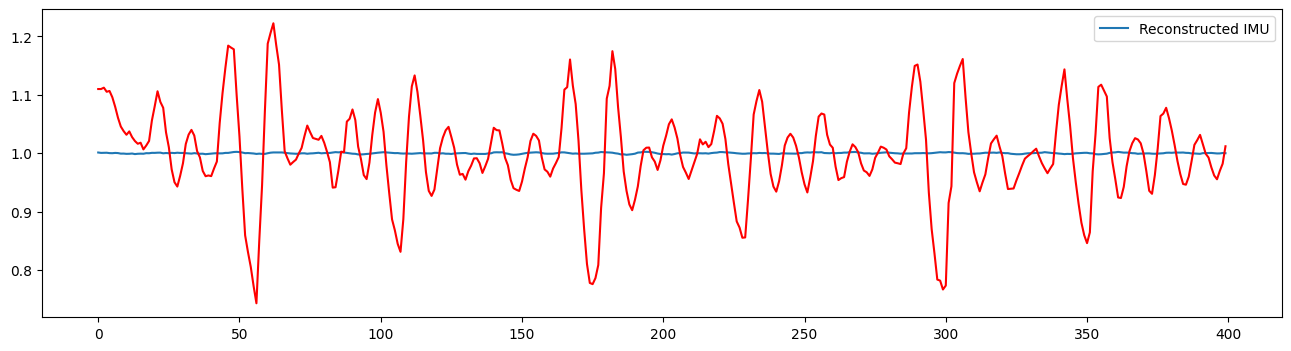

In [184]:
model.eval()
sample_idx = 668# print(audio.shape)5
# Change this to the index of the sample you want to load
spec, image, audio,_,_ = val_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
imu = image
x_audio_recon,x_imu_recon,z_combined,gamma = model(audio, image)

# total_loss, sample_energy, recon_error, cov_diag = model.loss_function(audio,x_audio_recon,imu,x_imu_recon, z_combined, gamma,0.1, 0.005)
# target_zero = random_tensor.unsqueeze(0).expand(1, -1)
# svdd_loss = loss_function(anomaly_score, target_zero)
sample_energy, cov_diag = model.compute_energy(z_combined,phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)

print(sample_energy)
# print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
# print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(audio.cpu().numpy().squeeze()[0])
plt.plot(x_audio_recon.cpu().detach().numpy().squeeze()[0], label='Reconstructed Audio')
plt.legend()

plt.figure(figsize=(16, 4))
plt.plot(x_imu_recon.cpu().detach().numpy().squeeze(), label='Reconstructed IMU')
plt.plot(image.cpu().numpy().squeeze(), 'r')
plt.legend()


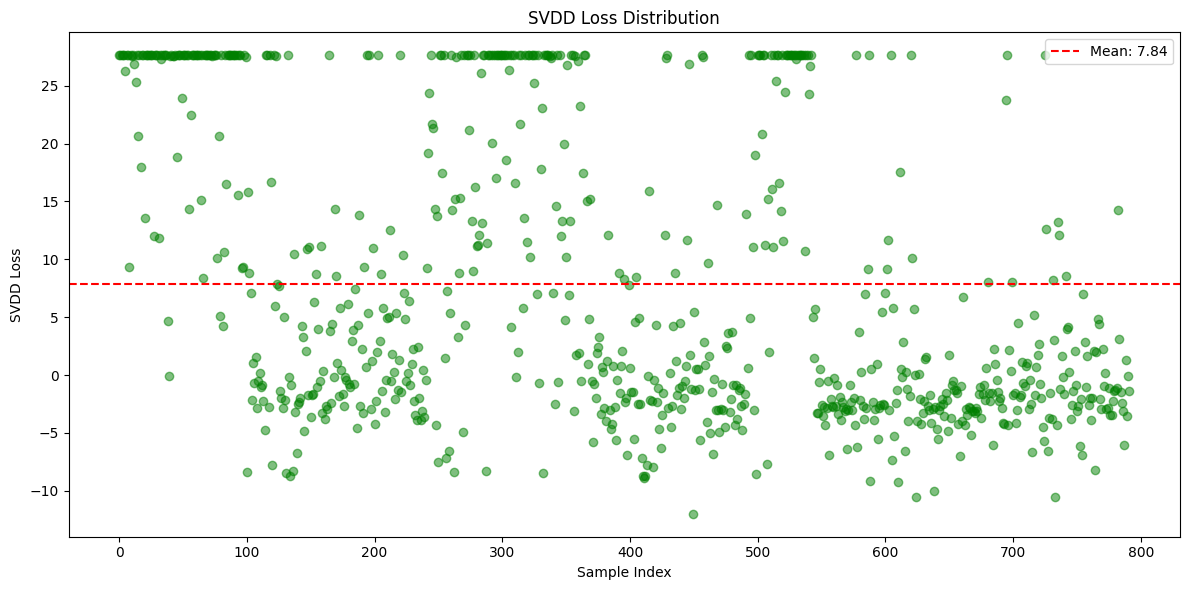

In [185]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio,_,_ = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # print(image.shape,audio.shape,sample_idx)
    # Forward pass through the model
        imu = image
        x_audio_recon,x_imu_recon,z_combined,gamma = model(audio, image)
        
        # total_loss, sample_energy, recon_error, cov_diag = model.loss_function(audio,x_audio_recon,imu,x_imu_recon, z_combined, gamma,0.1, 0.005)
        # target_zero = random_tensor.unsqueeze(0).expand(1, -1)
        # svdd_loss = loss_function(anomaly_score, target_zero)
        sample_energy, cov_diag = model.compute_energy(z_combined,phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)


        # Calculate SVDD loss for the sample
        svdd_loss = sample_energy
        # print(total_loss, sample_energy, recon_error)


        # Append individual loss values to the lists
        # reconstruction_losses_val.append(recon_error.item())
        svdd_losses_val.append(svdd_loss.item())
        # total_losses_val.append(total_loss.item())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
# mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
# mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
# plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Reconstruction Loss')
# plt.title('Reconstruction Loss Distribution')
# # plt.ylim(min(reconstruction_losses), 0.8)
# plt.legend()

plt.subplot(1, 1, 1)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.32)
plt.legend()

# plt.subplot(1, 3, 3)
# plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
# plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Total Loss')
# plt.title('Total Loss Distribution')
# # plt.ylim(min(total_losses),2)
# plt.legend()

plt.tight_layout()
plt.show()

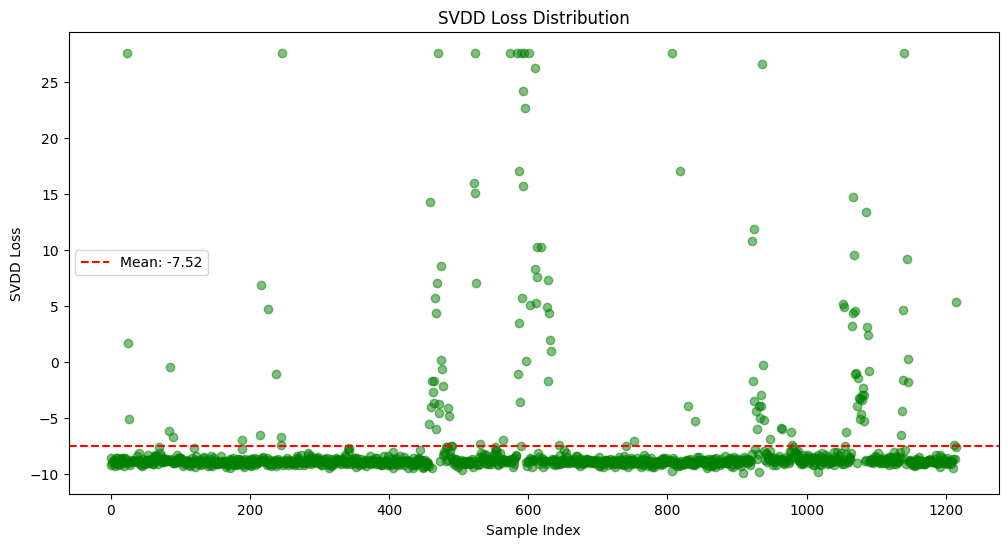

In [186]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []

# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio,_,_ = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu,_ = model(audio, image)

        # Calculate reconstruction loss for the sample
        imu = image
        x_audio_recon,x_imu_recon,z_combined,gamma = model(audio, image)
        
        # total_loss, sample_energy, recon_error, cov_diag = model.loss_function(audio,x_audio_recon,imu,x_imu_recon, z_combined, gamma,0.1, 0.005)
        # target_zero = random_tensor.unsqueeze(0).expand(1, -1)
        # svdd_loss = loss_function(anomaly_score, target_zero)
        sample_energy, cov_diag = model.compute_energy(z_combined,phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)


        # Calculate SVDD loss for the sample
        svdd_loss = sample_energy

        # Append individual loss values to the lists
        # reconstruction_losses_train.append(recon_error.item())
        svdd_losses_train.append(svdd_loss.item())
        # total_losses_train.append(total_loss.item())

# Plotting the data distribution of losses using scatter plots
# mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
# mean_total_loss = sum(total_losses_train) / len(total_losses_train)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
# plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Reconstruction Loss')
# plt.title('Reconstruction Loss Distribution')
# # plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
# plt.legend()

plt.subplot(1, 1, 1)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses), max(svdd_losses)*1.1)
plt.legend()

# plt.subplot(1, 3, 3)
# plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
# plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Total Loss')
# plt.title('Total Loss Distribution')
# # plt.ylim(min(total_losses), max(total_losses)*1.1)
# plt.legend()

# plt.tight_layout()
# plt.show()

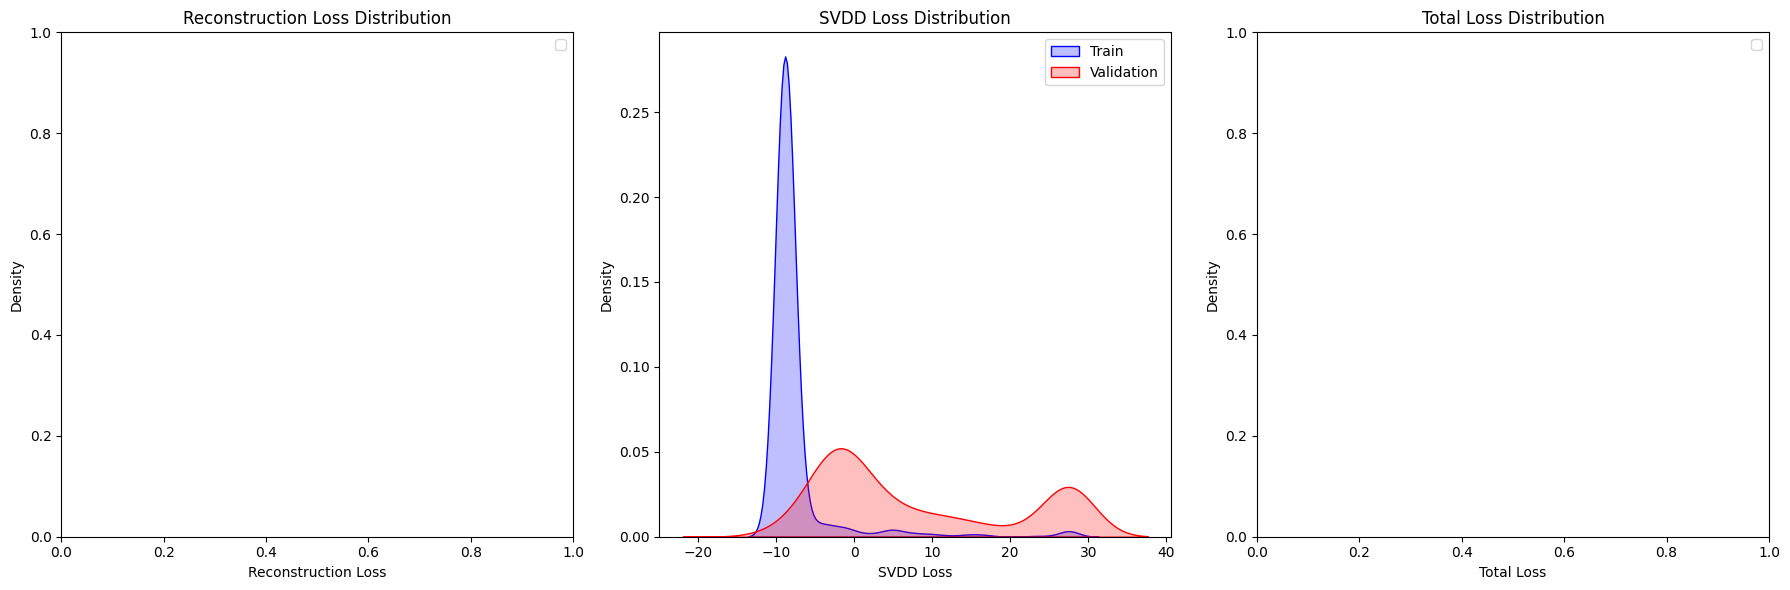

In [187]:
import seaborn as sns

# Plotting KDE plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(reconstruction_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(reconstruction_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(svdd_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(svdd_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 40)
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(total_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(total_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


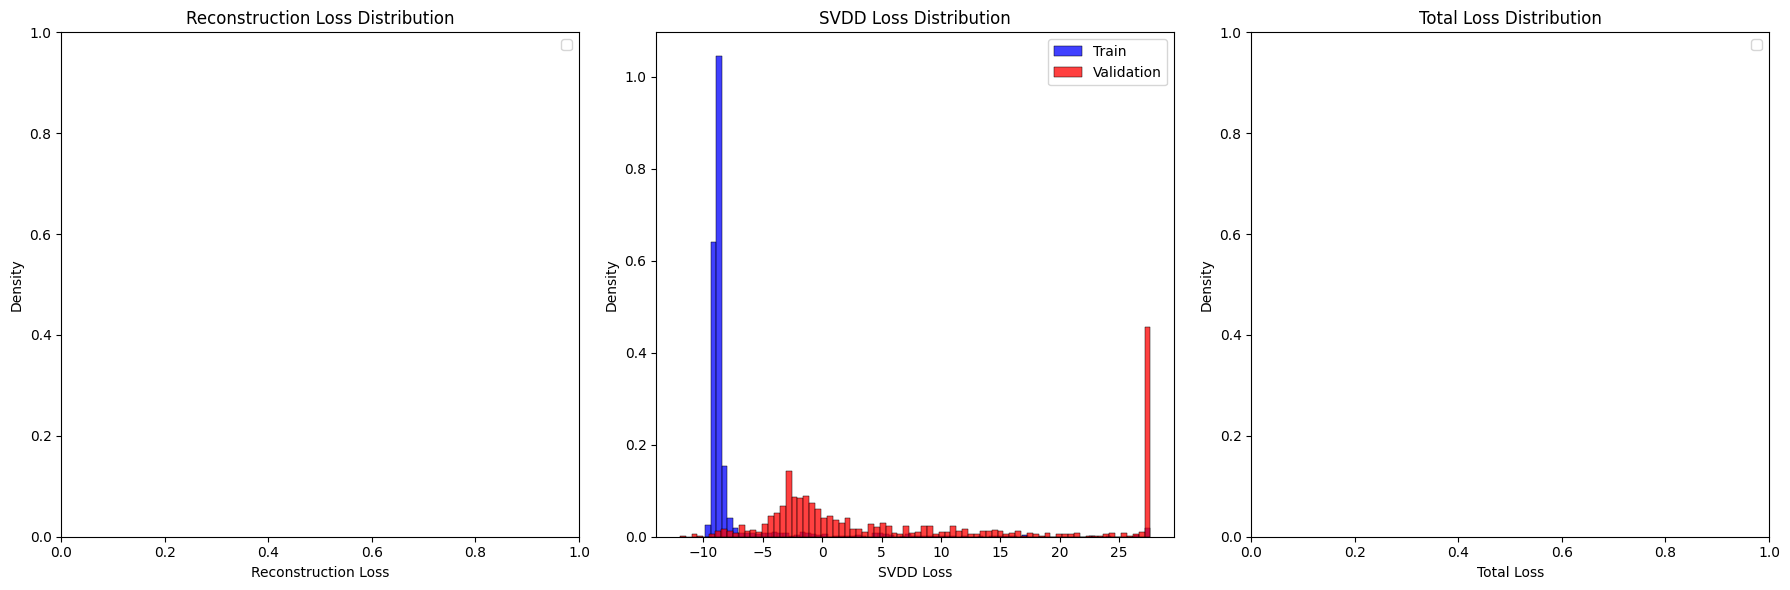

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histograms
plt.figure(figsize=(18, 6))

# Plot for Reconstruction Loss Distribution
plt.subplot(1, 3, 1)
sns.histplot(reconstruction_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(reconstruction_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

# Plot for SVDD Loss Distribution
plt.subplot(1, 3, 2)
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 0.4)
plt.legend()

# Plot for Total Loss Distribution
plt.subplot(1, 3, 3)
sns.histplot(total_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(total_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')

plt.legend()

plt.tight_layout()
plt.show()


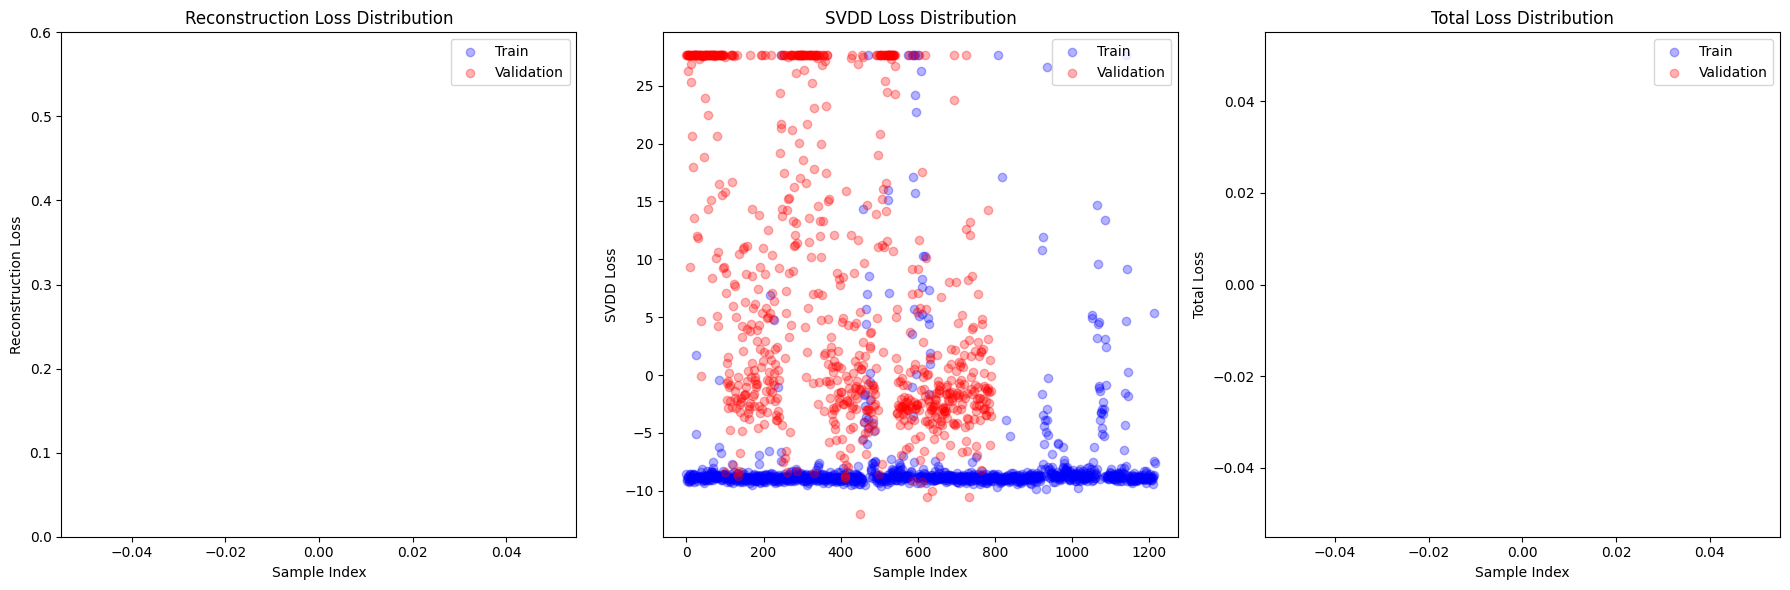

In [189]:
import matplotlib.pyplot as plt

# Plotting scatter plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(reconstruction_losses_train)), reconstruction_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(reconstruction_losses_val)), reconstruction_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(0,0.6)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.3)
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(total_losses_train)), total_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(total_losses_val)), total_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
# plt.ylim(0.5,5)
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


In [190]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
print(eval_metrics_svdd[:-2])

(0.9500364458732057, 0.8961225588101306, 0.9138393429372372, 0.8630751964085297, 0.9709595959595959)


In [191]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (loss_all_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)
normal_list = train_data.audio_list
indoor_group = []
outdoor_group = []

for idx, filepath in enumerate(normal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    else:
        outdoor_group.append(idx)  # Add the index of the file
print(len(indoor_group),len(outdoor_group))
indoor_losses = [svdd_losses_train[idx] for idx in indoor_group]
outdoor_losses = [svdd_losses_train[idx] for idx in outdoor_group]

-7.333025932312012
642 574


In [192]:
recall[best_index]

0.9709595959595959

In [193]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.8997

Indoor Group Accuracy:
  Accuracy: 0.8847

Outdoor Group Accuracy:
  Accuracy: 0.9164


In [194]:
abnormal_list = val_data.audio_list
mach_group = []
coli_group = []

for idx, filepath in enumerate(abnormal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    # file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file
        
mach_losses = [svdd_losses_val[idx] for idx in mach_group]
coli_losses = [svdd_losses_val[idx] for idx in coli_group]
print(len(mach_losses),len(coli_losses))

513 279


In [195]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")


Overall Accuracy:
  Accuracy: 0.9697

mach Group Accuracy:
  Accuracy: 0.9649

coli Group Accuracy:
  Accuracy: 0.9785


In [181]:
# np.save("dagmm_P",eval_metrics_svdd[-2])
# np.save("dagmm_r",eval_metrics_svdd[-1])

In [112]:
# from deepod.metrics import ts_metrics
# from deepod.metrics import point_adjustment 
# def z_score_normalization(data):
#     mean = np.mean(data)
#     std_dev = np.std(data)
#     normalized_data = [(x - mean) / std_dev for x in data]
#     return normalized_data


# loss_all_audio = svdd_losses_train+svdd_losses_val
# loss_all_audio = np.array(loss_all_audio)
# loss_all_audio = z_score_normalization(loss_all_audio)


# loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
# loss_all_recons = np.array(loss_all_recons)
# loss_all_recons = z_score_normalization(loss_all_recons)

In [113]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data

def z_score_normalization2(data):
    normalized_data = data-min(data)/(max(data)-min(data))
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
w2 = []
for loss in loss_all_audio:
    if loss > 1.75:
        w = 0
    else:
        w = 0.5
    w2.append(w)

# Compute w1 as the complement of w2
w1 = [1 - w for w in w2]
loss_all_audio = np.array(loss_all_audio)
loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
loss_all_recons = z_score_normalization(loss_all_recons)

/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/iot/anaconda3/envs/ai/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [99]:
# labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
# loss_all = [0.5*x + 0.5*y for x, y in zip(loss_all_audio, loss_all_recons)]


In [100]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [ x + 7*y for w1_i, w2_i, x, y in zip(w1, w2, loss_all_audio, loss_all_recons)]

In [101]:
eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
eval_metrics_recons = ts_metrics(labels_all, (loss_all_recons))
eval_metrics_all = ts_metrics(labels_all, (loss_all))

ValueError: Found input variables with inconsistent numbers of samples: [2008, 0]

In [18]:
print(eval_metrics_svdd)
print(eval_metrics_recons)
print(eval_metrics_all)

(0.9063174923577884, 0.7776897684325919, 0.8709444525877194, 0.7921406411582212, 0.9671717171717171, array([0.39442231, 0.39412058, 0.39431705, ..., 0.75409836, 0.73684211,
       1.        ]), array([1.        , 0.99873737, 0.99873737, ..., 0.05808081, 0.0530303 ,
       0.        ]))


NameError: name 'eval_metrics_recons' is not defined

In [33]:
# x = np.load('/home/iot/collision_detect/OmniAnomaly/processed/SMAP_test.pkl',allow_pickle=True)

In [28]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# model.eval()
# random_tensor = torch.load('center.pth').to(device)
# true_labels = []
# predicted_labels = []
# threshold = 0.45

# with torch.no_grad():
#     for sample_idx in range(len(val_data)):
#         spec, image, audio = val_data[sample_idx]

#         spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

#         anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

#         reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio) * 10

#         target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

#         # Calculate SVDD loss for the sample
#         svdd_loss = loss_function(anomaly_score, target_zero)*100

#         # Calculate total loss for the sample
#         total_loss = svdd_loss + reconstruction_loss

#         # Predict class based on total loss
#         if svdd_loss<=mean_svdd_loss:
#             predicted_class=0
#         else:
#             predicted_class=1

#         # Handle ground truth class
#         true_class = 1

#         # Update confusion matrix variables
#         true_labels.append(true_class)
#         predicted_labels.append(predicted_class)

# # Construct confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# print("Confusion Matrix:")
# print(conf_matrix)


In [380]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# from svdd_detectnet import DetectNet
import torch.nn.functional as F
import importlib
import torch
import numpy as np
from torch.nn.utils import weight_norm


def _handle_n_hidden(n_hidden):
    if type(n_hidden) == int:
        n_layers = 1
        hidden_dim = n_hidden
    elif type(n_hidden) == str:
        n_hidden = n_hidden.split(',')
        n_hidden = [int(a) for a in n_hidden]
        n_layers = len(n_hidden)
        hidden_dim = int(n_hidden[0])

    else:
        raise TypeError('n_hidden should be a string or a int.')

    return hidden_dim, n_layers

def _instantiate_class(module_name: str, class_name: str):
    module = importlib.import_module(module_name)
    class_ = getattr(module, class_name)
    return class_()

class ConvSeqEncoder(torch.nn.Module):
    """
    this network architecture is from NeurTraL-AD
    """
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqEncoder, self).__init__()

        n_hidden, _ = _handle_n_hidden(n_hidden)

        self.bias = bias
        self.batch_norm = batch_norm
        self.activation = activation

        enc = [self._make_layer(n_features, n_hidden, (3,1,1))]
        in_dim = n_hidden
        window_size = seq_len
        for i in range(n_layers - 2):
            out_dim = n_hidden*2**i
            enc.append(self._make_layer(in_dim, out_dim, (3,2,1)))
            in_dim =out_dim
            window_size = np.floor((window_size+2-3)/2)+1

        self.enc = torch.nn.Sequential(*enc)
        self.final_layer = torch.nn.Conv1d(in_dim, n_output, int(window_size), 1, 0)

    def _make_layer(self, in_dim, out_dim, conv_param):
        down_sample = None
        if conv_param is not None:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=conv_param[0], stride=conv_param[1], padding=conv_param[2],
                                          bias=self.bias)
        elif in_dim != out_dim:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=1, stride=1, padding=0,
                                          bias=self.bias)

        layer = ConvResBlock(in_dim, out_dim, conv_param, down_sample=down_sample,
                             batch_norm=self.batch_norm, bias=self.bias, activation=self.activation)

        return layer

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.enc(x)
        z = self.final_layer(z)
        return z.squeeze(-1)


class ConvResBlock(torch.nn.Module):
    """Convolutional Residual Block"""
    def __init__(self, in_dim, out_dim, conv_param=None, down_sample=None,
                 batch_norm=False, bias=False, activation='ReLU'):
        super(ConvResBlock, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_dim, in_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if conv_param is not None:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         conv_param[0], conv_param[1], conv_param[2],bias=bias)
        else:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         kernel_size=3, stride=1, padding=1, bias=bias)

        self.conv3 = torch.nn.Conv1d(in_dim, out_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if batch_norm:
            self.bn1 = torch.nn.BatchNorm1d(in_dim)
            self.bn2 = torch.nn.BatchNorm1d(in_dim)
            self.bn3 = torch.nn.BatchNorm1d(out_dim)
            if down_sample:
                self.bn4 = torch.nn.BatchNorm1d(out_dim)

        self.act = _instantiate_class("torch.nn.modules.activation", activation)
        self.down_sample = down_sample
        self.batch_norm = batch_norm

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.act(out)

        out = self.conv3(out)
        if self.batch_norm:
            out = self.bn3(out)

        if self.down_sample is not None:
            residual = self.down_sample(x)
            if self.batch_norm:
                residual = self.bn4(residual)

        out += residual
        out = self.act(out)

        return out

class ConvSeqDecoder(nn.Module):
    """
    Decoder architecture for ConvSeqEncoder, which reconstructs the input sequence
    from the encoded latent space representation.
    """
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqDecoder, self).__init__()

        n_hidden, _ = _handle_n_hidden(n_hidden)

        self.bias = bias
        self.batch_norm = batch_norm
        self.activation = activation

        dec = []

        # Calculate the initial dimensions and window size for the first layer of the decoder
        in_dim = n_output  # This should match the output channels of the encoder
        window_size = seq_len

        for i in range(n_layers - 2):
            out_dim = n_hidden * 2 ** (n_layers - i - 3)
            dec.append(self._make_layer(in_dim, out_dim, (3, 2, 1)))
            in_dim = out_dim
            window_size = np.ceil((window_size - 1) * 2 - 2)

        # Add the final layer to reconstruct to the original input features
        self.dec = nn.Sequential(*dec)
        self.final_layer = nn.ConvTranspose1d(in_dim, n_features, kernel_size=(3,), stride=(1,), padding=(1,))

    def _make_layer(self, in_dim, out_dim, conv_param):
        up_sample = nn.ConvTranspose1d(
            in_channels=in_dim, out_channels=out_dim,
            kernel_size=conv_param[0], stride=conv_param[1], padding=conv_param[2],
            bias=self.bias
        )
        layer = ConvResBlock(in_dim, out_dim, conv_param, down_sample=up_sample,
                             batch_norm=self.batch_norm, bias=self.bias, activation=self.activation)

        return layer

    def forward(self, x):
        # Input is expected to be (batch_size, channels, sequence_length)
        z = self.dec(x)
        z = self.final_layer(z)
        return z

# Define Autoencoder Class
class ConvSeqAutoencoder(nn.Module):
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqAutoencoder, self).__init__()
        self.encoder = ConvSeqEncoder(n_features, n_hidden, n_output, n_layers, seq_len, bias, batch_norm, activation)
        self.decoder = ConvSeqDecoder(n_features, n_hidden, n_output, n_layers, seq_len, bias, batch_norm, activation)

    def forward(self, x):
        # Expecting input shape to be (batch_size, seq_len, n_features)
        # Permute to (batch_size, n_features, seq_len) for Conv1d

        encoded = self.encoder(x)
        # x = x.permute(0, 2, 1)
        print(x.shape)
        decoded = self.decoder(encoded)
        # Permute back to original input shape
        decoded = decoded.permute(0, 2, 1)
        return decoded

# Example Usage
if __name__ == "__main__":
    # Hyperparameters
    seq_len = 100
    n_features = 16
    batch_size = 8

    # Initialize the model
    autoencoder = ConvSeqAutoencoder(n_features=n_features, seq_len=seq_len)

    # Example input (batch_size, seq_len, n_features)
    input_data = torch.randn(batch_size, seq_len, n_features)  # Random synthetic data

    # Forward pass
    reconstructed_data = autoencoder(input_data)

    # Print the shapes to verify
    print(f"Input data shape: {input_data.shape}")
    print(f"Reconstructed data shape: {reconstructed_data.shape}")




torch.Size([8, 100, 16])


RuntimeError: Given groups=1, weight of size [128, 128, 1], expected input[1, 8, 128] to have 128 channels, but got 8 channels instead

In [362]:
model = ConvSeqEncoder(n_features=33, n_hidden='512', n_layers=4, seq_len=100, batch_norm=False,
                       n_output=1, activation='LeakyReLU')
print(model)
a = torch.randn(32, 100, 33)

b =  model(a)
print(b.shape)

ConvSeqEncoder(
  (enc): Sequential(
    (0): ConvResBlock(
      (conv1): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(33, 33, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv3): Conv1d(33, 512, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(33, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ConvResBlock(
      (conv1): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    )
    (2): ConvResBlock(
      (conv1): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(n

In [10]:
conf_matrix = np.array([[267, 105],[48, 278]])

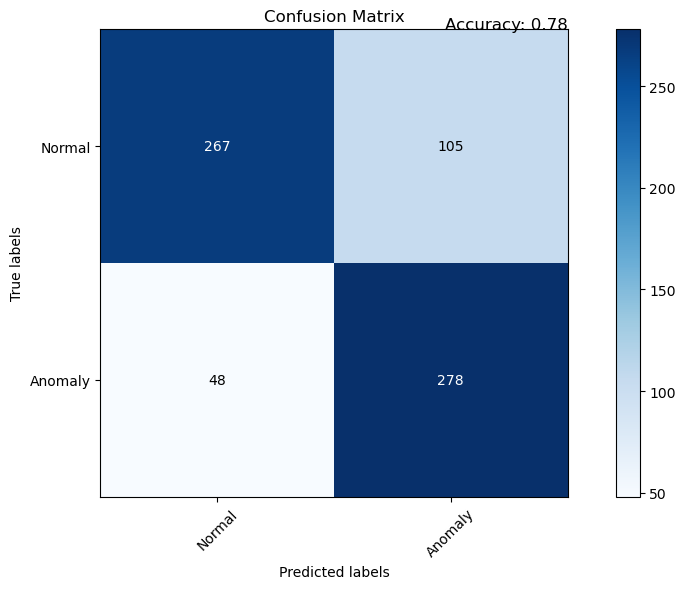

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()


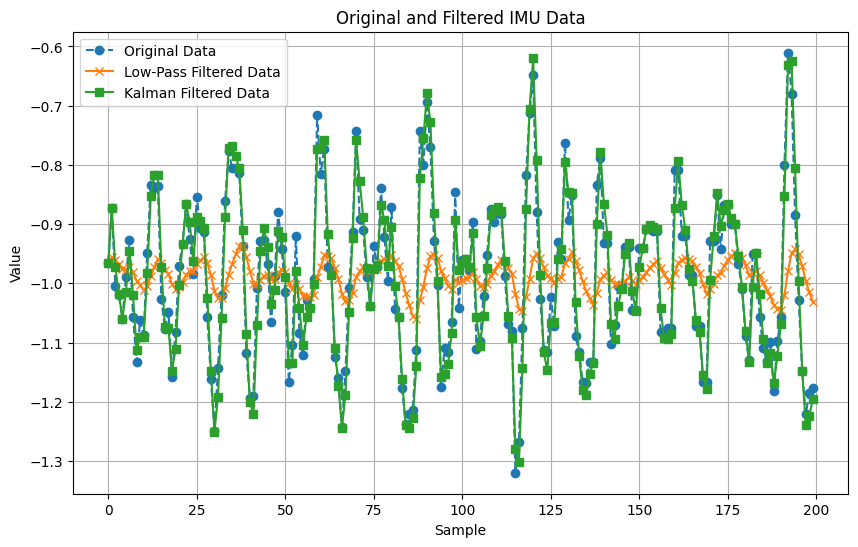

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Low-Pass Filter Class
class LowPassFilter:
    def __init__(self, alpha):
        self.alpha = alpha
        self.state = None

    def filter(self, value):
        if self.state is None:
            self.state = value
        else:
            self.state = self.alpha * value + (1 - self.alpha) * self.state
        return self.state

# Kalman Filter Function
def apply_kalman_filter(data, R, Q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # initial state (position and velocity)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = R  # measurement noise
    kf.Q = Q  # process noise

    filtered_data = []

    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])  # we are interested in the position

    return np.array(filtered_data)

# Example IMU data (numpy array)
imu_data = np.load('/home/iot/collision_detect/data/imu/normal_train/normal_5/85.npy')[:,-1][:1000]
# Apply Low-Pass Filter
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in imu_data])

# Apply Kalman Filter
R = 0.1  # Example measurement noise
Q = 0.1  # Example process noise
kf_filtered_data = apply_kalman_filter(imu_data, R, Q)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(imu_data, label='Original Data', linestyle='--', marker='o')
plt.plot(lpf_filtered_data, label='Low-Pass Filtered Data', linestyle='-', marker='x')
plt.plot(kf_filtered_data, label='Kalman Filtered Data', linestyle='-', marker='s')

plt.title('Original and Filtered IMU Data')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
x = np.load('/home/iot/collision_detect/new_data/imu_np/Abnormal/fl/20.npy')[:,-1]
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in x])

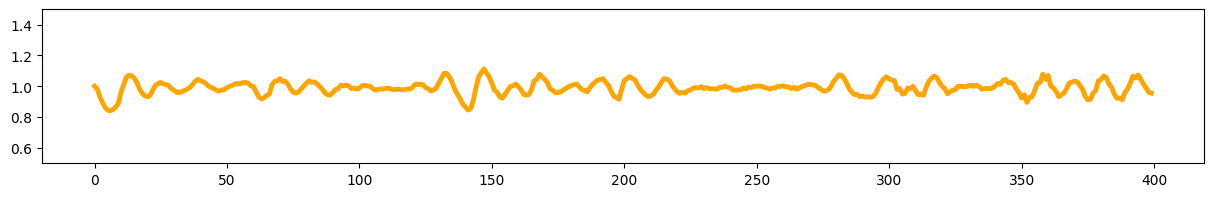

In [66]:
plt.figure(figsize=(15, 2))
plt.ylim(0.5,1.5)
plt.plot(lpf_filtered_data,color='orange',linewidth=3.5)

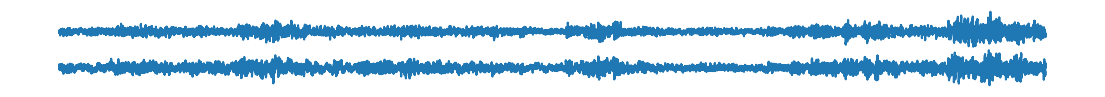

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Load the audio data
audio_data = np.load('/home/iot/collision_detect/new_data/audio_np/Abnormal/fl/20.npy')

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 1))

# Plot the first audio signal
axs[0].plot(audio_data[0])
axs[0].axis('off')  # Turn off the axis
# axs[0].set_ylim(-0.1, 0.1) 
# Plot the second audio signal
axs[1].plot(audio_data[1])
axs[1].axis('off')  # Turn off the axis
# axs[1].set_ylim(-0.1, 0.1) 
# Adjust layout to have no space between plots
plt.subplots_adjust(hspace=0.001)

# Display the plot
plt.show()
